# 작업할 내용

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

# 모듈 

In [2]:
import konlpy
import gensim

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from konlpy.tag import Okt
from konlpy.tag import Kkma

from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split


# 변수 초기화

In [3]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
max_sequence_length = 30
word_vector_dim = 100

In [4]:
okt = Okt()
kkma = Kkma()

# 데이터 확인

In [5]:
# 데이터 불러오기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [6]:
train_data.shape

(150000, 3)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


document 컬럼에 5개가 null

In [8]:
test_data.shape

(50000, 3)

In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


# NaN 결측치 제거

In [10]:
nan_label = train_data[train_data["document"].isna() == True]
nan_label

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [11]:
for i in nan_label.index:
    train_data.drop(index=i, inplace=True)

train_data[train_data["document"].isna() == True]

,id,document,label


In [12]:
nan_label = test_data[test_data["document"].isna() == True]
nan_label

,id,document,label
5746,402110,NaN,1
7899,5026896,NaN,0
27097,511097,NaN,1


In [13]:
for i in nan_label.index:
    test_data.drop(index=i, inplace=True)

test_data[test_data["document"].isna() == True]

,id,document,label


# 데이터 중복 제거

In [14]:
train_data[train_data.duplicated(['document']) == True]

,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1
...,...,...,...
149919,6502490,짱,1
149949,3924716,OO 영화,0
149960,6368431,지루하다,0
149966,6735753,1,0


> 중복 데이터를 지워야 하는가?

- 감성 분석에는 보존하는게 좋다고 함.
- 텍스트 분류나 토픽 모델링 할 때는 지우는 게 좋다고 함

In [15]:
train_data[train_data.duplicated(['id']) == True]

,id,document,label


말 그대로 레이블 자체가 중복된 데이터는 없음

In [16]:
train_data.shape

(149995, 3)

# 토큰화

In [17]:
# 토큰화
train_data['tokenized'] = train_data['document'].apply(okt.morphs)

In [18]:
test_data['tokenized'] = test_data['document'].apply(okt.morphs)

시간이 꽤 걸림...

In [19]:
# 백업용 데이터 생성
train_data_org = train_data.copy()

In [20]:
test_data_org = test_data.copy()

In [21]:
# 복원
# train_data = train_data_org.copy()
train_data_org.shape

(149995, 4)

In [22]:
train_data.head()

,id,document,label,tokenized
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[아, 더빙, .., 진짜, 짜증나네요, 목소리]"
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,"[흠, ..., 포스터, 보고, 초딩, 영화, 줄, ...., 오버, 연기, 조차,..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너, 무재, 밓었, 다그, 래서, 보는것을, 추천, 한, 다]"
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[교도소, 이야기, 구먼, .., 솔직히, 재미, 는, 없다, .., 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[사이, 몬페, 그, 의, 익살스런, 연기, 가, 돋보였던, 영화, !, 스파이더맨..."


In [23]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149995 entries, 0 to 149999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         149995 non-null  int64 
 1   document   149995 non-null  object
 2   label      149995 non-null  int64 
 3   tokenized  149995 non-null  object
dtypes: int64(2), object(2)
memory usage: 5.7+ MB


# 불용어 제거

In [24]:
# 불용어 포함된 텍스트 확인
df_stop = train_data[train_data['tokenized'].apply(lambda x: any(word in x for word in stopwords))]

In [25]:
# 불용어 포함된 텍스트 확인
df_stop_test = test_data[test_data['tokenized'].apply(lambda x: any(word in x for word in stopwords))]

In [26]:
df_stop.head()

,id,document,label,tokenized
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너, 무재, 밓었, 다그, 래서, 보는것을, 추천, 한, 다]"
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[교도소, 이야기, 구먼, .., 솔직히, 재미, 는, 없다, .., 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[사이, 몬페, 그, 의, 익살스런, 연기, 가, 돋보였던, 영화, !, 스파이더맨..."
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0,"[막, 걸음, 마, 뗀, 3, 세, 부터, 초등학교, 1, 학년, 생인, 8, 살용..."
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0,"[원작, 의, 긴장감, 을, 제대로, 살려내지못, 했다, .]"


In [27]:
df_stop.shape

(104137, 4)

In [28]:
df_stop_test.shape

(34977, 4)

In [29]:
# 불용어 제거
train_data.loc[:, 'tokenized'] = train_data['tokenized'].apply(lambda x: [word for word in x if word not in stopwords])

In [30]:
# 불용어 제거
test_data.loc[:, 'tokenized'] = test_data['tokenized'].apply(lambda x: [word for word in x if word not in stopwords])

In [31]:
# 제거 확인
train_data[train_data['tokenized'].apply(lambda x: any(word in x for word in stopwords))]

,id,document,label,tokenized


In [32]:
# 제거 확인
test_data[test_data['tokenized'].apply(lambda x: any(word in x for word in stopwords))]

,id,document,label,tokenized


In [33]:
train_data.shape

(149995, 4)

In [34]:
test_data.shape

(49997, 4)

# word to index

## 고유 단어

In [35]:
df_merge = pd.concat([train_data['tokenized'], test_data['tokenized']])

In [36]:
df_merge.info()

<class 'pandas.core.series.Series'>
Index: 199992 entries, 0 to 49999
Series name: tokenized
Non-Null Count   Dtype 
--------------   ----- 
199992 non-null  object
dtypes: object(1)
memory usage: 3.1+ MB


In [37]:
unique_words = set([word for words in df_merge for word in words])
df_unique = pd.DataFrame(list(unique_words))
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122876 entries, 0 to 122875
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       122876 non-null  object
dtypes: object(1)
memory usage: 960.1+ KB


In [38]:
df_unique.tail()

,0
122871,뻔할
122872,저조했던
122873,헷헷
122874,있었다
122875,쓸쓸했던


In [39]:
df_unique['count'] = 0

In [40]:
df_unique.columns.values[0] = 'word'

In [41]:
df_unique.tail()

,word,count
122871,뻔할,0
122872,저조했던,0
122873,헷헷,0
122874,있었다,0
122875,쓸쓸했던,0


## 단어 인덱스

In [42]:
word_index = {}

In [43]:
def words_to_indices(texts):
    
    # 0: '<PAD>' ; 패딩용 단어
    # 1: '<BOS>' ; 문장의 시작지점
    # 2: '<UNK>' ; 사전에 없는(Unknown) 단어

    index = 3  # Start indexing from 1 (0 can be used for padding or reserved for special tokens)

    indices = []
    for word in texts:
        if word not in word_index:
            word_index[word] = index
            index += 1
        indices.append(word_index[word])

    return indices

In [44]:
train_data.loc[:, 'word_index'] = train_data['tokenized'].apply(words_to_indices)

In [45]:
test_data.loc[:, 'word_index'] = test_data['tokenized'].apply(words_to_indices)

In [46]:
train_data['word_index'].head()

0                                   [3, 4, 5, 6, 7, 8]
1        [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
2                            [3, 4, 5, 6, 7, 8, 9, 10]
3                      [3, 4, 5, 5, 6, 7, 8, 5, 9, 10]
4    [3, 4, 5, 6, 12, 7, 8, 8, 9, 10, 11, 12, 13, 1...
Name: word_index, dtype: object

In [48]:
row_with_max_items = train_data.loc[train_data['word_index'].apply(lambda x: len(x)).idxmax()]
print(row_with_max_items)

id                                                      7978306
document      임시완 보아 커플 최다니엘 김지원 커플 보러 가자 연장 고 고 고 고 고 고 고 고...
label                                                         1
tokenized     [임시완, 보아, 커플, 최다니엘, 김지원, 커플, 보러, 가자, 연장, 고, 고,...
word_index    [3, 22, 8, 3, 3, 8, 6, 3, 12, 6, 6, 6, 6, 6, 6...
Name: 149047, dtype: object


## max length

In [49]:
df_len = train_data['word_index'].apply(lambda x: len(x))

In [50]:
df_len_test = test_data['word_index'].apply(lambda x: len(x))

In [51]:
train_data['word_index_length'] = df_len

In [52]:
test_data['word_index_length'] = df_len_test

In [53]:
train_data.head()

,id,document,label,tokenized,word_index,word_index_length
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[아, 더빙, .., 진짜, 짜증나네요, 목소리]","[3, 4, 5, 6, 7, 8]",6
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,"[흠, ..., 포스터, 보고, 초딩, 영화, 줄, ...., 오버, 연기, 조차,...","[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]",13
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너, 무재, 밓었, 다그, 래서, 보는것을, 추천, 다]","[3, 4, 5, 6, 7, 8, 9, 10]",8
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[교도소, 이야기, 구먼, .., 솔직히, 재미, 없다, .., 평점, 조정]","[3, 4, 5, 5, 6, 7, 8, 5, 9, 10]",10
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[사이, 몬페, 그, 익살스런, 연기, 돋보였던, 영화, !, 스파이더맨, 에서, ...","[3, 4, 5, 6, 12, 7, 8, 8, 9, 10, 11, 12, 13, 1...",18


(array([2.3605e+04, 5.1311e+04, 3.4000e+04, 1.5080e+04, 8.1870e+03,
        4.7810e+03, 3.4320e+03, 2.1610e+03, 2.4290e+03, 2.6230e+03,
        1.7130e+03, 4.5500e+02, 1.6700e+02, 3.8000e+01, 9.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 0.  ,  4.75,  9.5 , 14.25, 19.  , 23.75, 28.5 , 33.25, 38.  ,
        42.75, 47.5 , 52.25, 57.  , 61.75, 66.5 , 71.25, 76.  , 80.75,
        85.5 , 90.25, 95.  ]),
 <BarContainer object of 20 artists>)

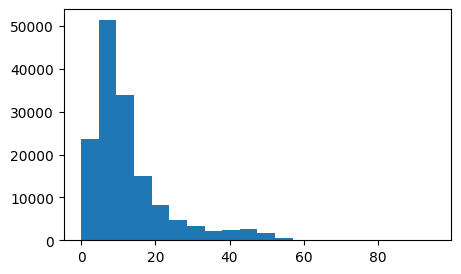

In [54]:
plt.figure(figsize=(5,3))
plt.hist(train_data['word_index_length'], bins=20)

(array([4.6380e+03, 1.4190e+04, 1.1246e+04, 7.7860e+03, 4.1460e+03,
        1.9400e+03, 1.3820e+03, 1.0330e+03, 8.6000e+02, 6.0600e+02,
        6.4200e+02, 7.3600e+02, 4.7200e+02, 2.0400e+02, 6.9000e+01,
        2.9000e+01, 1.4000e+01, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.  ,  3.95,  7.9 , 11.85, 15.8 , 19.75, 23.7 , 27.65, 31.6 ,
        35.55, 39.5 , 43.45, 47.4 , 51.35, 55.3 , 59.25, 63.2 , 67.15,
        71.1 , 75.05, 79.  ]),
 <BarContainer object of 20 artists>)

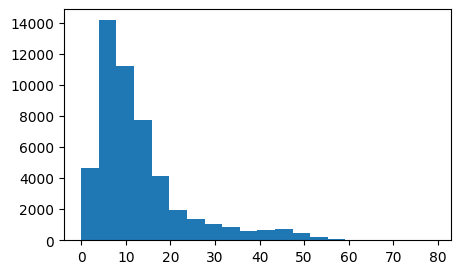

In [55]:
plt.figure(figsize=(5,3))
plt.hist(test_data['word_index_length'], bins=20)

In [56]:
train_data[train_data['word_index_length'] < 20].count()

id                   126253
document             126253
label                126253
tokenized            126253
word_index           126253
word_index_length    126253
dtype: int64

In [57]:
train_data[train_data['word_index_length'] > 80]

,id,document,label,tokenized,word_index,word_index_length
65113,8520307,강추@강추@강추@강추@강추@강추@강추@강추@강추@강추@강추@강추@강추@강추@강추@강...,1,"[강추, @, 강추, @, 강추, @, 강추, @, 강추, @, 강추, @, 강추,...","[5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, ...",93
116829,10002342,선유야 사랑해 우리 좀있다가 보자!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!...,1,"[선, 유야, 사랑, 해, 우리, 좀있다가, 보자, !!, ♥, !!, ♥, !!,...","[3, 4, 4, 16, 3, 3, 6, 11, 6, 11, 6, 11, 6, 11...",88
126174,9230852,내평점은쓰레기임 진심평점줬더만일분만에삭제댓음티비서 내돈주고만원내고제돈주고내평썻더만 ...,0,"[내, 평점, 쓰레기, 임, 진심, 평점, 줬, 더, 만일분, 만에, 삭제, 댓, ...","[11, 9, 4, 14, 4, 9, 7, 7, 3, 4, 7, 5, 9, 17, ...",81
149047,7978306,임시완 보아 커플 최다니엘 김지원 커플 보러 가자 연장 고 고 고 고 고 고 고 고...,1,"[임시완, 보아, 커플, 최다니엘, 김지원, 커플, 보러, 가자, 연장, 고, 고,...","[3, 22, 8, 3, 3, 8, 6, 3, 12, 6, 6, 6, 6, 6, 6...",95


## word embedding

In [58]:
vocab_size = df_unique.shape[0]
vocab_size

122876

In [59]:
seq_train = train_data['word_index']

In [60]:
seq_test = test_data['word_index']

In [61]:
X_train = pad_sequences(seq_train, maxlen=max_sequence_length, padding='post')

In [62]:
X_test = pad_sequences(seq_test, maxlen=max_sequence_length, padding='post')

# 모델링

- pad_sequences의 max_sequence_length에 따라 Conv1D 레이어 필터 크기에 제한이 있음
    - 최대 시퀀스 길이 30에 필터 크기는 5 적용

In [63]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         12287600  
                                                                 
 conv1d (Conv1D)             (None, None, 16)          8016      
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 16)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1296      
                                                                 
 global_max_pooling1d (Glob  (None, 16)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 8)                 1

## 학습용/테스트용 데이터 준비

In [64]:
# X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [65]:
# 타겟 레이블
y_train = train_data['label']

In [66]:
y_test = test_data['label']

In [67]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((149995, 30), (49997, 30), (149995,), (49997,))

## 학습

In [69]:
# Train the model
result = model.fit(X_train, y_train, batch_size=512, epochs=10)

Epoch 1/10
293/293 [==============================] - 12s 41ms/step - loss: 0.6693 - accuracy: 0.5831
Epoch 2/10
293/293 [==============================] - 12s 42ms/step - loss: 0.6624 - accuracy: 0.5933
Epoch 3/10
293/293 [==============================] - 11s 38ms/step - loss: 0.6582 - accuracy: 0.5998
Epoch 4/10
293/293 [==============================] - 12s 40ms/step - loss: 0.6555 - accuracy: 0.6018
Epoch 5/10
293/293 [==============================] - 12s 39ms/step - loss: 0.6531 - accuracy: 0.6049
Epoch 6/10
293/293 [==============================] - 11s 39ms/step - loss: 0.6514 - accuracy: 0.6071
Epoch 7/10
293/293 [==============================] - 11s 39ms/step - loss: 0.6499 - accuracy: 0.6096
Epoch 8/10
293/293 [==============================] - 11s 37ms/step - loss: 0.6487 - accuracy: 0.6099
Epoch 9/10
293/293 [==============================] - 11s 37ms/step - loss: 0.6478 - accuracy: 0.6115
Epoch 10/10
293/293 [==============================] - 11s 37ms/step - loss: 0.646

# loss, accuracy

In [70]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1563/1563 [==============================] - 2s 630us/step - loss: 0.6583 - accuracy: 0.5964
Test Loss: 0.6583
Test Accuracy: 0.5964


Loss, Accuracy.... 수치가 엉망...

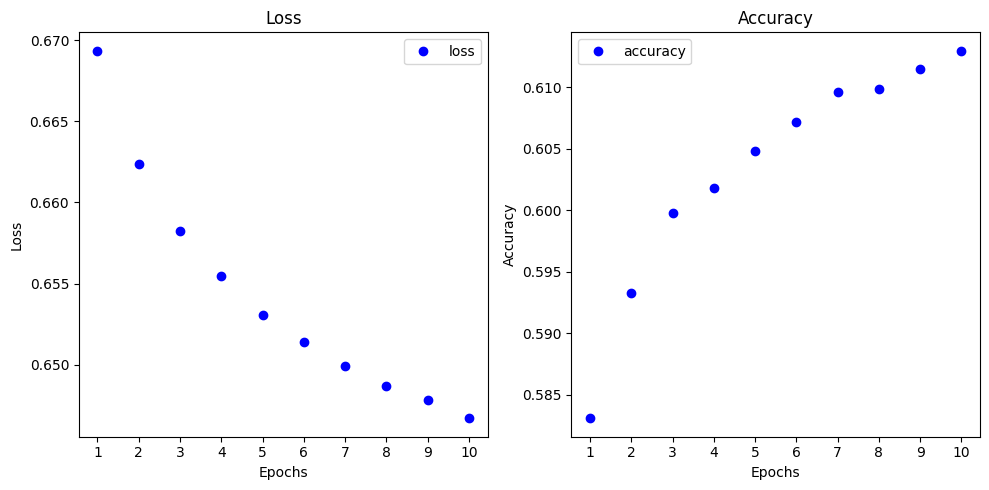

In [71]:
plt.figure(figsize=(10, 5))
epochs = range(1, len(result.history['loss']) + 1)

# loss
plt.subplot(1, 2, 1)
plt.plot(epochs, result.history['loss'], 'bo', label='loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(epochs) + 1))
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, result.history['accuracy'], 'bo', label='accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(epochs) + 1))
plt.legend()

plt.tight_layout()
plt.show()

# embedding layer

In [92]:
trained_embedding_layer = model.get_layer('embedding_1')

In [94]:
embedding_weights = trained_embedding_layer.get_weights()[0]
print(embedding_weights.shape)
print(embedding_weights[0])

(302960, 100)
[-0.03976415  0.01021079 -0.04208941  0.044492   -0.049851   -0.02090743
 -0.00649316 -0.00074304  0.00971865  0.01641292 -0.04029448  0.01403819
  0.02454592  0.01042168  0.04990584  0.03383619 -0.01843408  0.01763899
  0.00351451 -0.0296787   0.0252458   0.01127524  0.04763342  0.02045817
 -0.0341746   0.04368705  0.00216533  0.01322505  0.03759887  0.03740876
  0.03657265  0.00102683  0.01383657  0.00429256  0.02873207  0.03889245
 -0.01472729  0.04414315 -0.00260661 -0.0073343   0.0087917   0.01037253
  0.00296643  0.00765232  0.04596582  0.01537435  0.02101911 -0.04664106
 -0.04749234  0.01341278 -0.02184982  0.00817071 -0.03318582 -0.0236683
 -0.00861131 -0.04888118 -0.00927486  0.01690251 -0.03843478  0.01785023
 -0.01406319 -0.0024286   0.03799312 -0.0305583   0.01996679  0.02842477
  0.02366946 -0.01904557  0.00475154  0.00328423  0.04302907  0.02846588
 -0.02389141  0.02072572  0.0408315   0.04649336 -0.02948152 -0.01147715
 -0.03695277 -0.00517129 -0.04629054 -

In [99]:
trained_embedding_layer.input_dim

302960

# load_data() 구성

In [165]:
df_train = train_data[:10].copy()
df_test = test_data[:10].copy()

In [155]:
# na 제거
def remove_na(df):
    nan_label = df[df.isna() == True]
    
    for i in nan_label.index:
        df.drop(index=i, inplace=True)
        
    return df

In [159]:
# 토큰화
def tokenize(df):
    return df.apply(okt.morphs)

In [166]:
# 불용어 제거
def remove_stopwords(df):
    return df.apply(lambda x: [word for word in x if word not in stopwords])

In [175]:
def load_data(train_data, test_data):
    
    """
    - 데이터의 중복 제거
    - NaN 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(Stopwords) 제거
    - 사전word_to_index 구성
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환
    - X_train, y_train, X_test, y_test, word_to_index 리턴
    """
    
    # na 제거
    train_data.loc[:, 'document'] = remove_na(train_data['document'])
    test_data.loc[:, 'document'] = remove_na(test_data['document'])
    
    # tokenize
    train_data['tokenized'] = tokenize(train_data['document'])
    test_data['tokenized'] = tokenize(test_data['document'])
    
    # 불용어 제거
    train_data.loc[:, 'tokenized'] = remove_stopwords(train_data['tokenized'])
    test_data.loc[:, 'tokenized'] = remove_stopwords(test_data['tokenized'])
    
    # 고유단어
    #df_merge = pd.concat([train_data['tokenized'], test_data['tokenized']])
    #unique_words = set([word for words in df_merge for word in words])
    
    # word to index
    word_index_dict = {}
    
    def words_to_indices(texts):    
        index = 3  # Start indexing from 1 (0 can be used for padding or reserved for special tokens)
        indices = []
        for word in texts:
            if word not in word_index_dict:
                word_index_dict[word] = index
                index += 1
            indices.append(word_index_dict[word])
        return indices
    
    train_data.loc[:, 'word_index'] = train_data['tokenized'].apply(words_to_indices)
    test_data.loc[:, 'word_index'] = test_data['tokenized'].apply(words_to_indices)
    
    
    # 임베딩
    seq_train = train_data['word_index']
    seq_test = test_data['word_index']
    X_train = pad_sequences(seq_train, maxlen=max_sequence_length, padding='post')
    X_test = pad_sequences(seq_test, maxlen=max_sequence_length, padding='post')
    
    return X_train, X_test, train_data['label'], test_data['label'], word_index_dict

In [176]:
X_train, X_test, y_train, y_test, word_to_index = load_data(df_train, df_test)

In [171]:
len(word_to_index)

209

In [178]:
X_train[0], X_test[0], y_train[0], y_test[0]

(array([3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 0,
 1)

# word2vec

In [72]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = './word2vec_ko.model'
wv_model = Word2VecKeyedVectors.load(word2vec_file_path)
wv = wv_model.wv

In [73]:
def words_to_indices_wv(texts):
    
    indices = []
    for word in texts:
        if word in wv:
            indices.append(wv[word])

    return indices

In [74]:
train_data.loc[:, 'wv'] = train_data['tokenized'].apply(words_to_indices_wv)

In [75]:
test_data.loc[:, 'wv'] = test_data['tokenized'].apply(words_to_indices_wv)

In [76]:
vocab_size = len(wv)
vocab_size

302960

In [77]:
seq_train_wv = train_data['wv']

In [78]:
seq_test_wv = test_data['wv']

In [79]:
seq_train_wv.shape, seq_test_wv.shape

((149995,), (49997,))

In [80]:
seq_train_wv[0][0].shape

(100,)

In [81]:
df_len = seq_train_wv.apply(lambda x: len(x))

(array([4.0946e+04, 5.3892e+04, 2.7923e+04, 9.2170e+03, 6.0830e+03,
        3.9010e+03, 2.5950e+03, 2.7120e+03, 1.7810e+03, 6.1200e+02,
        2.5600e+02, 5.7000e+01, 1.2000e+01, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 0. ,  4.7,  9.4, 14.1, 18.8, 23.5, 28.2, 32.9, 37.6, 42.3, 47. ,
        51.7, 56.4, 61.1, 65.8, 70.5, 75.2, 79.9, 84.6, 89.3, 94. ]),
 <BarContainer object of 20 artists>)

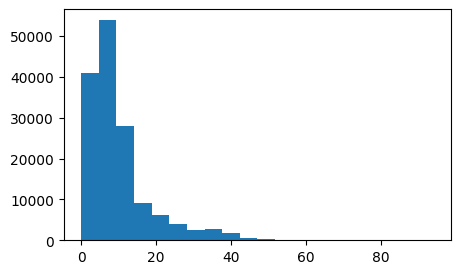

In [82]:
plt.figure(figsize=(5,3))
plt.hist(df_len, bins=20)

In [83]:
max_sequence_length = 30

In [84]:
X_train_wv = pad_sequences(seq_train_wv, maxlen=max_sequence_length, padding='post')

In [85]:
X_test_wv = pad_sequences(seq_test_wv, maxlen=max_sequence_length, padding='post')

In [86]:
X_train_wv.shape, X_test_wv.shape

((149995, 30, 100), (49997, 30, 100))

In [87]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         30296000  
                                                                 
 conv1d_2 (Conv1D)           (None, None, 16)          11216     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 16)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 8)                

In [192]:
# train
model.fit(X_train_wv, y_train, batch_size=32, epochs=1)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_14/embedding_13/embedding_lookup' defined at (most recent call last):
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/r0/w084nh2s0v3fstg3n70027500000gn/T/ipykernel_7424/2073901463.py", line 2, in <module>
      model.fit(X_train_wv, y_train, batch_size=32, epochs=1)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/salgu/miniconda3/envs/py38/lib/python3.8/site-packages/keras/src/layers/core/embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_14/embedding_13/embedding_lookup'
indices[26,1,2] = -3 is not in [0, 122876)
	 [[{{node sequential_14/embedding_13/embedding_lookup}}]] [Op:__inference_train_function_49029]

중간에... 왜 4개로 늘어나는거지???